In [17]:
import os
import glob
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from itertools import compress

sys.path.append('../')
import src.utils as my_u
from src.utils import df_cp
from src.utils import df_log
from src.utils import df_total20000
from src.utils import df_minmax
from src.utils import df_minmax_scaler
from src.utils import df_l2norm
from src.utils import df_zscore
from src.utils import df_meansquare
from src.utils import run_plot
import random

import scanpy

# Tabula Muris FACS & 10x common organ

In [2]:
tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*.csv")
print(len(tabula_file_list))
#print(tabula_file_list)
# Tabula data load
#
tabula_labels = []
for ff in tabula_file_list:
    tabula_labels += [ff.split('/')[-1].split('-')[0]]
tabula_labels_set = set(tabula_labels)
print(tabula_labels_set)


20
{'Liver', 'Limb_Muscle', 'Tongue', 'Spleen', 'Lung', 'Skin', 'Trachea', 'Diaphragm', 'Thymus', 'Pancreas', 'Fat', 'Brain_Myeloid', 'Heart', 'Large_Intestine', 'Bladder', 'Marrow', 'Kidney', 'Aorta', 'Brain_Non', 'Mammary_Gland'}


In [3]:
tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*")
print(len(tabula_10xfile_list))
#print(tabula_10xfile_list)

# Tabula data load


tabula_10x_labels = []
for ff in tabula_10xfile_list:
    tabula_10x_labels += [ff.split('/')[-1].split('-')[0]]

tabula_10x_labels_set = set(tabula_10x_labels)
print(tabula_10x_labels_set)

28
{'Liver', 'Thymus', 'Limb_Muscle', 'Tongue', 'Marrow', 'Spleen', 'Heart_and_Aorta', 'Lung', 'Mammary_Gland', 'Trachea', 'Bladder', 'Kidney'}


In [4]:
set(tabula_labels_set) & set(tabula_10x_labels_set)

{'Bladder',
 'Kidney',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'Mammary_Gland',
 'Marrow',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [5]:
mouse_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/metadata_droplet.csv', sep=',', header=0)
mouse_dic = dict(mouse_label[['channel','mouse.id']].values)
mouse_dic

{'10X_P4_0': '3-M-8',
 '10X_P4_1': '3-M-9',
 '10X_P4_2': '3-M-8/9',
 '10X_P4_3': '3-M-8',
 '10X_P4_4': '3-M-9',
 '10X_P4_5': '3-M-8',
 '10X_P4_6': '3-M-9',
 '10X_P4_7': '3-M-8',
 '10X_P7_0': '3-F-56',
 '10X_P7_1': '3-F-57',
 '10X_P7_2': '3-F-56',
 '10X_P7_3': '3-F-57',
 '10X_P7_4': '3-F-56',
 '10X_P7_5': '3-F-57',
 '10X_P7_6': '3-F-56',
 '10X_P7_7': '3-F-56',
 '10X_P7_8': '3-F-56',
 '10X_P7_9': '3-F-57',
 '10X_P7_10': '3-F-56',
 '10X_P7_11': '3-F-56',
 '10X_P7_12': '3-F-56',
 '10X_P7_13': '3-F-57',
 '10X_P7_14': '3-F-56',
 '10X_P7_15': '3-F-57',
 '10X_P8_12': '3-M-5/6',
 '10X_P8_13': '3-M-7/8',
 '10X_P8_14': '3-M-5/6',
 '10X_P8_15': '3-M-7/8'}

# one organ 
{'Bladder',
 'Kidney',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'Mammary_Gland',
 'Marrow',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

['../data/tabular_muris/00_facs_raw_data/FACS/Bladder-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P4_4', '../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P7_7', '../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P4_3']
(1638, 23433)
{'mesenchymal cell', 'bladder cell', 'basal cell of urothelium'}
(1783, 23433)
(2351, 23433)
(2500, 23433)
{'mesenchymal cell', 'bladder cell', 'endothelial cell', 'leukocyte', 'basal cell of urothelium'}

Summary
(3787, 23432)
{'Bladder'}
{'mesenchymal cell', 'bladder cell', 'endothelial cell', 'leukocyte', 'basal cell of urothelium'}
{'FACS_3_38_F', 'FACS_3_10_M', '10x_3-F-56', 'FACS_3_8_M', 'FACS_3_56_F', '10x_3-M-9', 'FACS_3_39_F', 'FACS_3_9_M', '10x_3-M-8'}


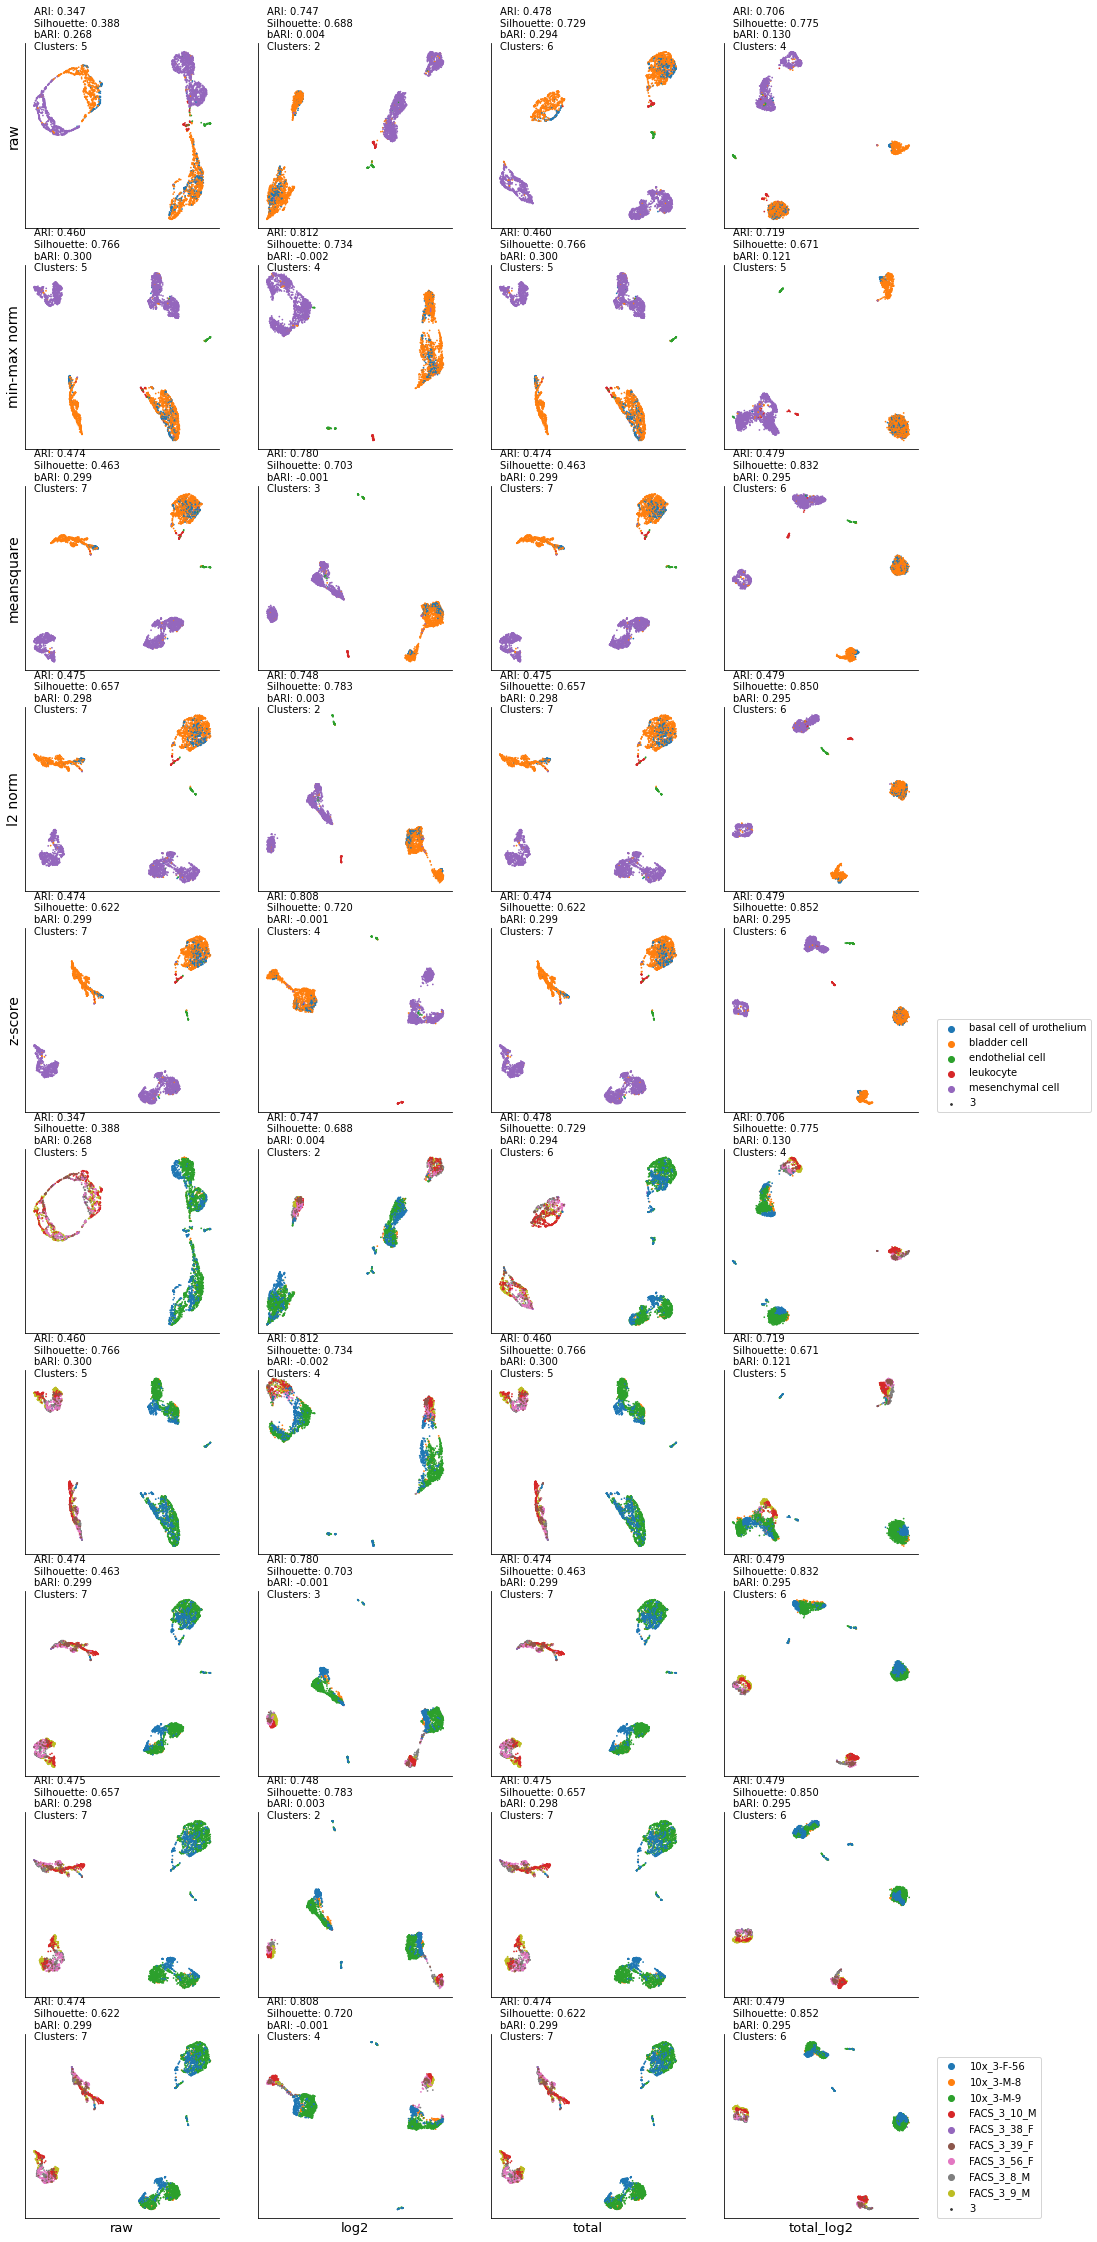

In [6]:
ORGAN = 'Bladder'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Kidney-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P7_5', '../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P4_6', '../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P4_5']
(865, 23433)
{'kidney collecting duct cell', 'endothelial cell', 'fibroblast', 'fenestrated cell', 'leukocyte', 'kidney tubule cell'}
(1264, 23433)
(2172, 23433)
(2782, 23433)
{'kidney collecting duct cell', 'macrophage', 'endothelial cell', 'fibroblast', 'fenestrated cell', 'leukocyte', 'smooth muscle cell', 'kidney tubule cell'}

Summary
(3298, 23432)
{'Kidney'}
{'kidney collecting duct cell', 'macrophage', 'endothelial cell', 'fibroblast', 'fenestrated cell', 'leukocyte', 'smooth muscle cell', 'kidney tubule cell'}
{'FACS_3_10_M', 'FACS_3_38_F', '10x_3-F-57', 'FACS_3_8_M', 'FACS_3_11_M', '10x_3-M-9', 'FACS_3_39_F', 'FACS_3_9_M', '10x_3-M-8'}


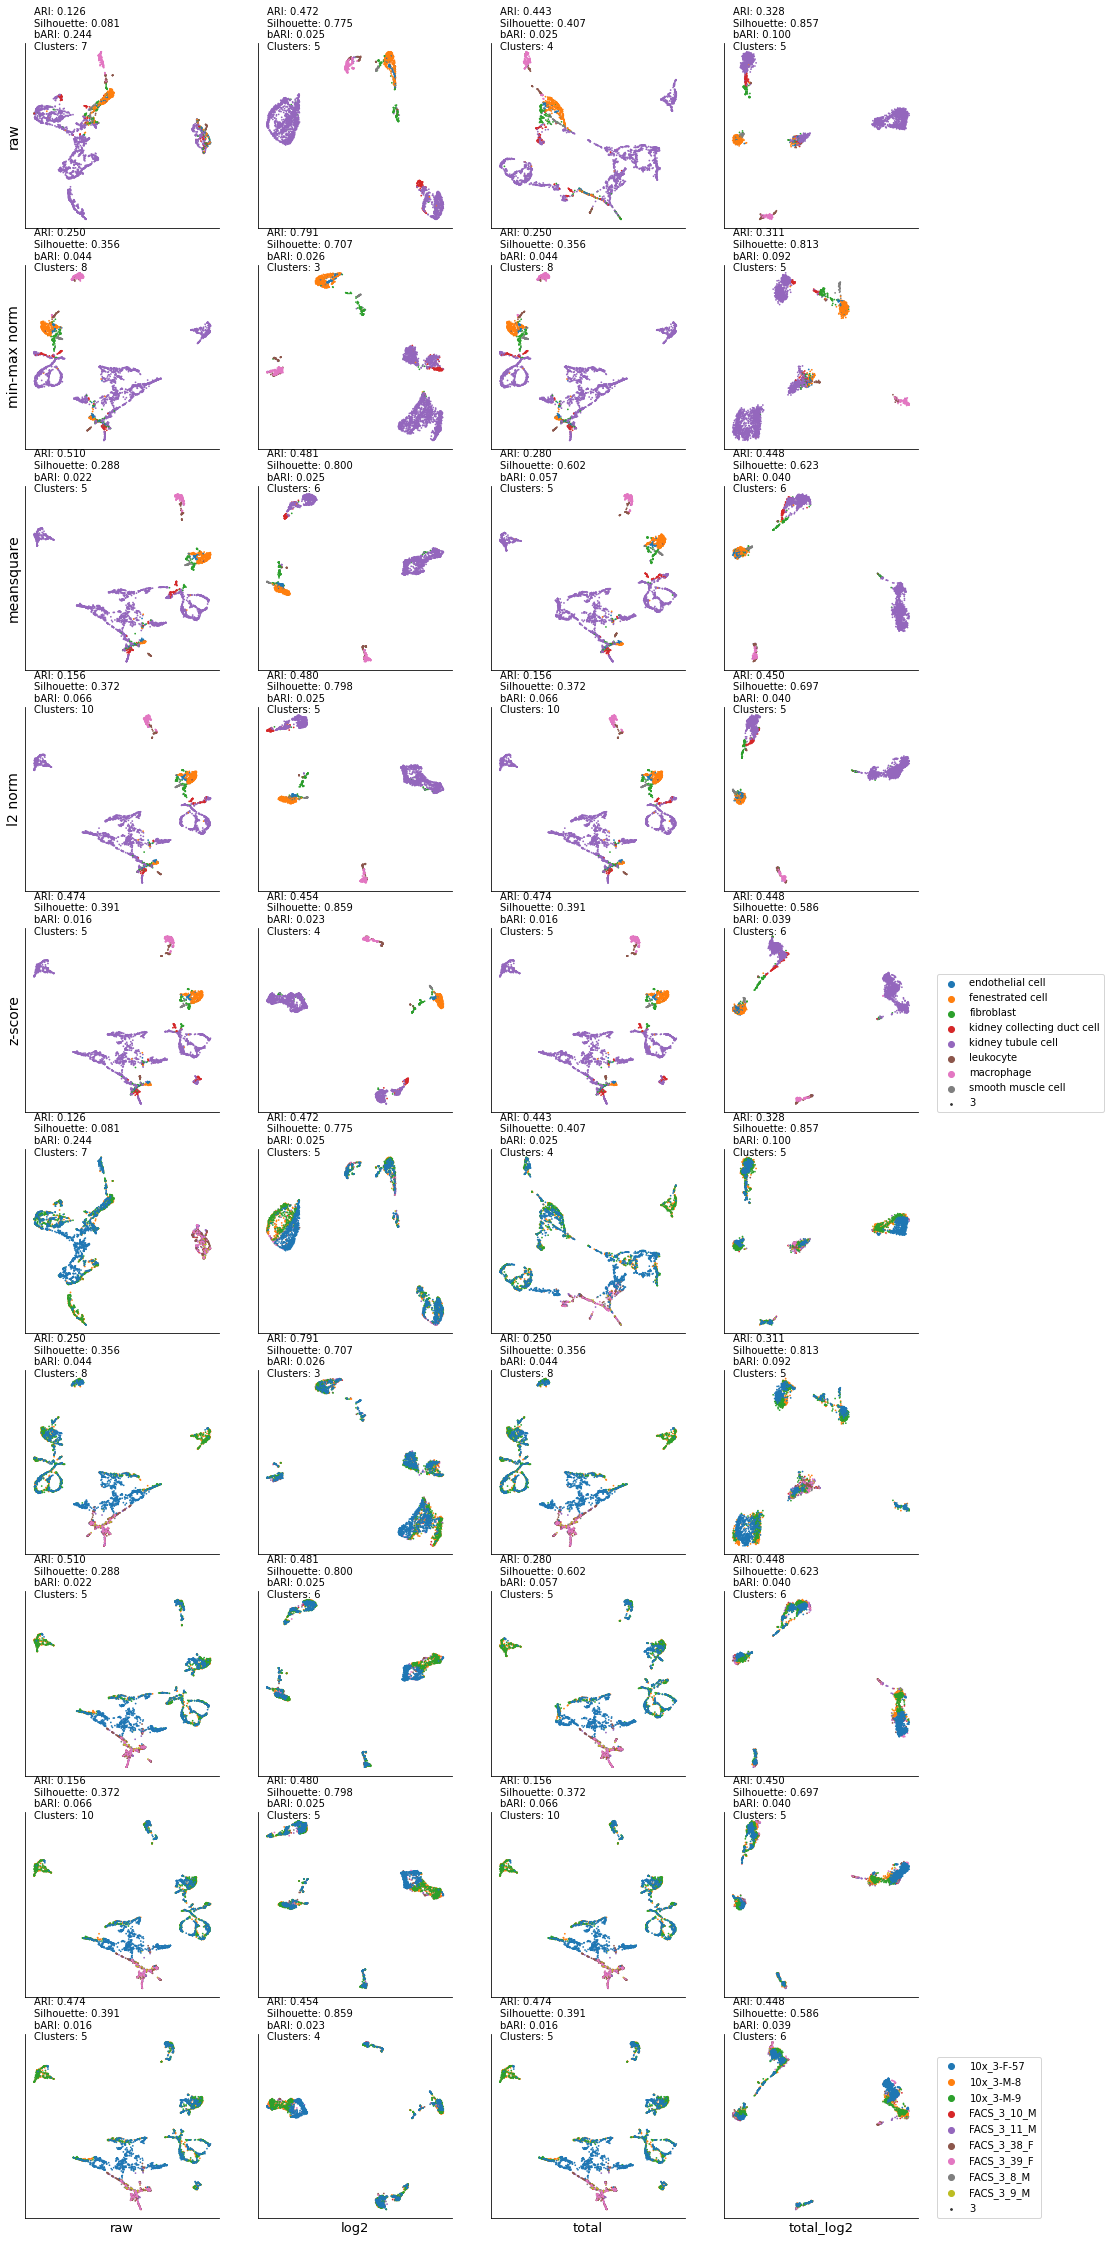

In [7]:
ORGAN = 'Kidney'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Limb_Muscle-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Limb_Muscle-10X_P7_14', '../data/tabular_muris/01_droplet_raw_data/droplet/Limb_Muscle-10X_P7_15']
(1151, 23433)
{'macrophage', 'B cell', 'endothelial cell', 'skeletal muscle satellite cell', 'mesenchymal stem cell', 'T cell'}
(2242, 23433)
(4543, 23433)
{'macrophage', 'chondroblast', 'B cell', 'endothelial cell', 'unknown', 'skeletal muscle satellite cell', 'mesenchymal stem cell', 'T cell'}

Summary
(5603, 23432)
{'Limb_Muscle'}
{'macrophage', 'chondroblast', 'B cell', 'endothelial cell', 'unknown', 'skeletal muscle satellite cell', 'mesenchymal stem cell', 'T cell'}
{'FACS_3_38_F', 'FACS_3_10_M', '10x_3-F-57', '10x_3-F-56', 'FACS_3_8_M', 'FACS_3_11_M', 'FACS_3_39_F', 'FACS_3_9_M'}


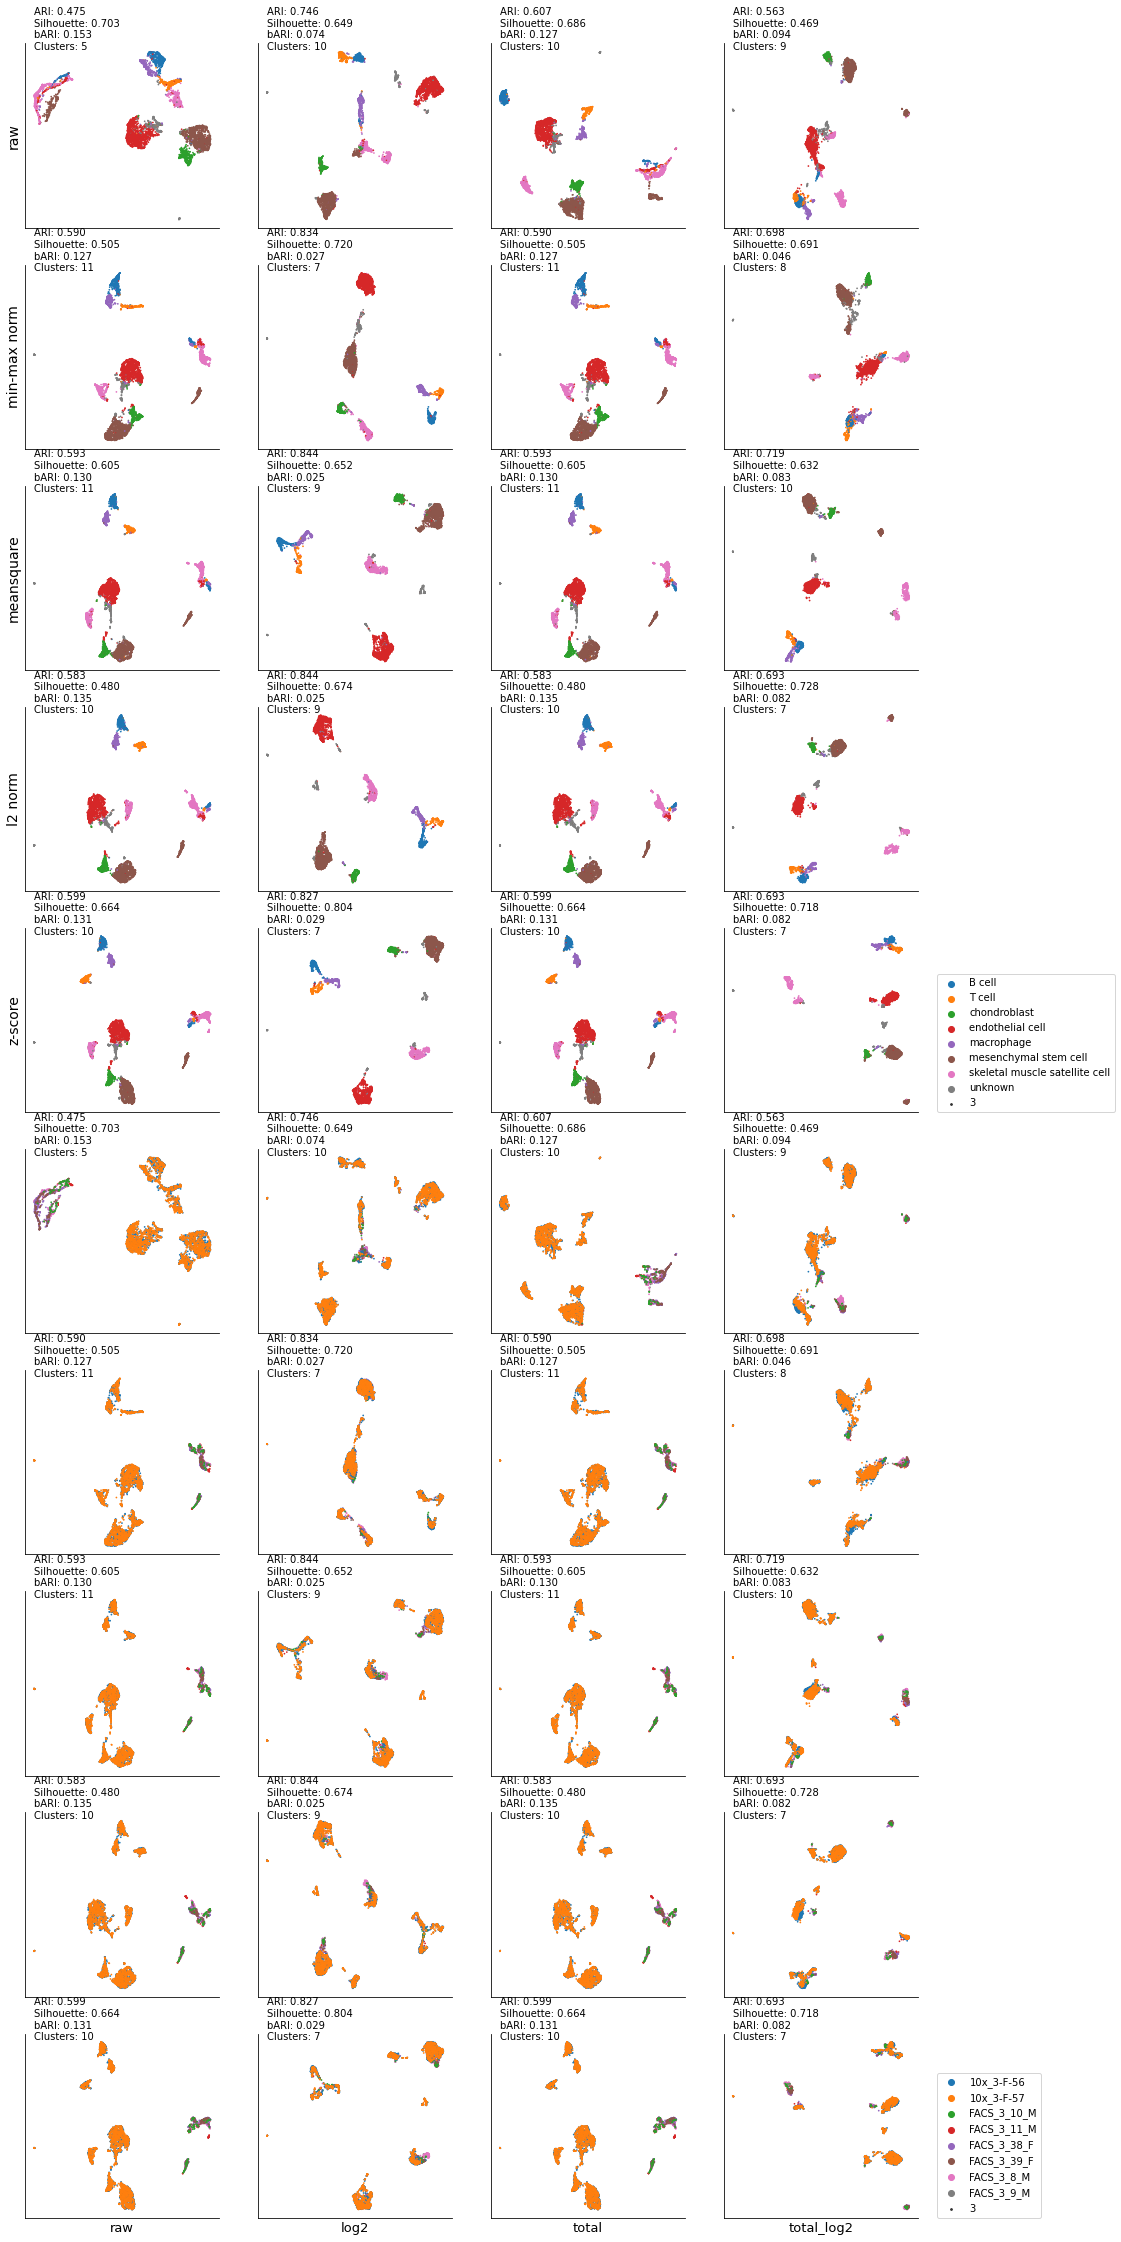

In [8]:
ORGAN = 'Muscle'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )

latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )

############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Liver-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P7_0', '../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P4_2', '../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P7_1']
(981, 23433)
{'B cell', 'hepatocyte', 'endothelial cell of hepatic sinusoid', 'natural killer cell', 'Kupffer cell'}
(596, 23433)
(1602, 23433)
(1924, 23433)
{'hepatocyte', 'endothelial cell'}

Summary
(1736, 23432)
{'Liver'}
{'B cell', 'endothelial cell', 'hepatocyte', 'endothelial cell of hepatic sinusoid', 'natural killer cell', 'Kupffer cell'}
{'10x_3-F-57', 'FACS_3_57_F', '10x_3-F-56', 'FACS_3_11_M', 'FACS_3_56_F', '10x_3-M-8/9', 'FACS_3_9_M'}


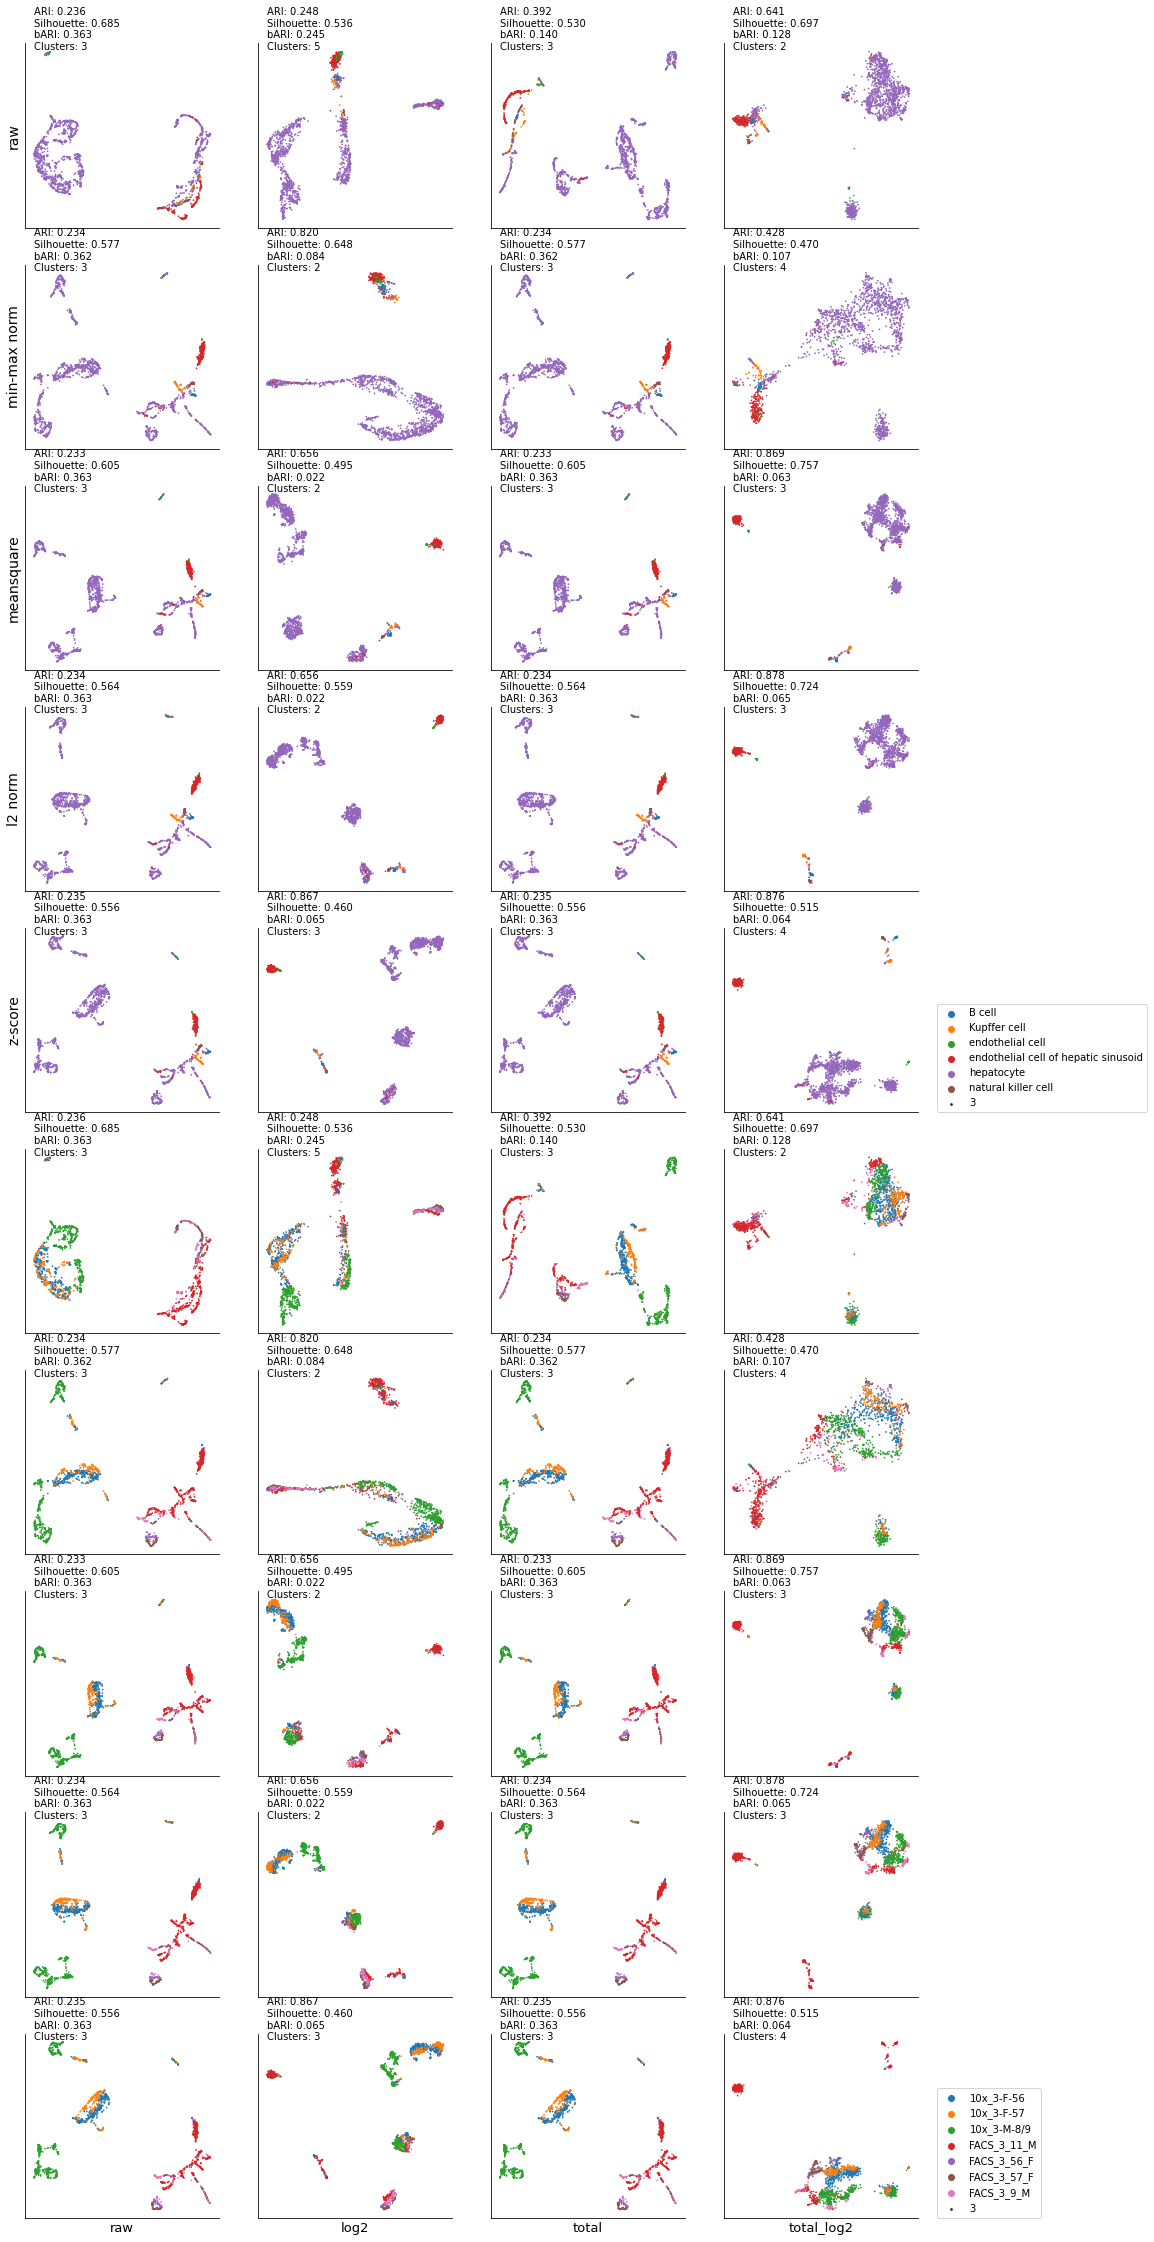

In [9]:
ORGAN = 'Liver'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))


total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Lung-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P8_13', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P7_9', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P7_8', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P8_12']
(1923, 23433)
{'type II pneumocyte', 'Clara cell', 'macrophage', 'B cell', 'endothelial cell', 'dendritic cell', 'stromal cell', 'epithelial cell', 'lung neuroendocrine cell', 'type I pneumocyte', 'natural killer cell', 'leukocyte', 'ciliated cell', 'monocyte', 'mesothelial cell', 'T cell'}
(2000, 23433)
(3525, 23433)
(4150, 23433)
(6150, 23433)
{'type II pneumocyte', 'Clara cell', 'macrophage', 'B cell', 'endothelial cell', 'dendritic cell', 'unknown', 'stromal cell', 'mast cell', 'leukocyte', 'ciliated cell', 'natural killer cell', 'mesothelial cell', 'monocyte', 'T cell'}

Summary
(3768, 23432)
{'Lung'}
{'type II pneumocyte', 'Clara cell', 'macrophage', 

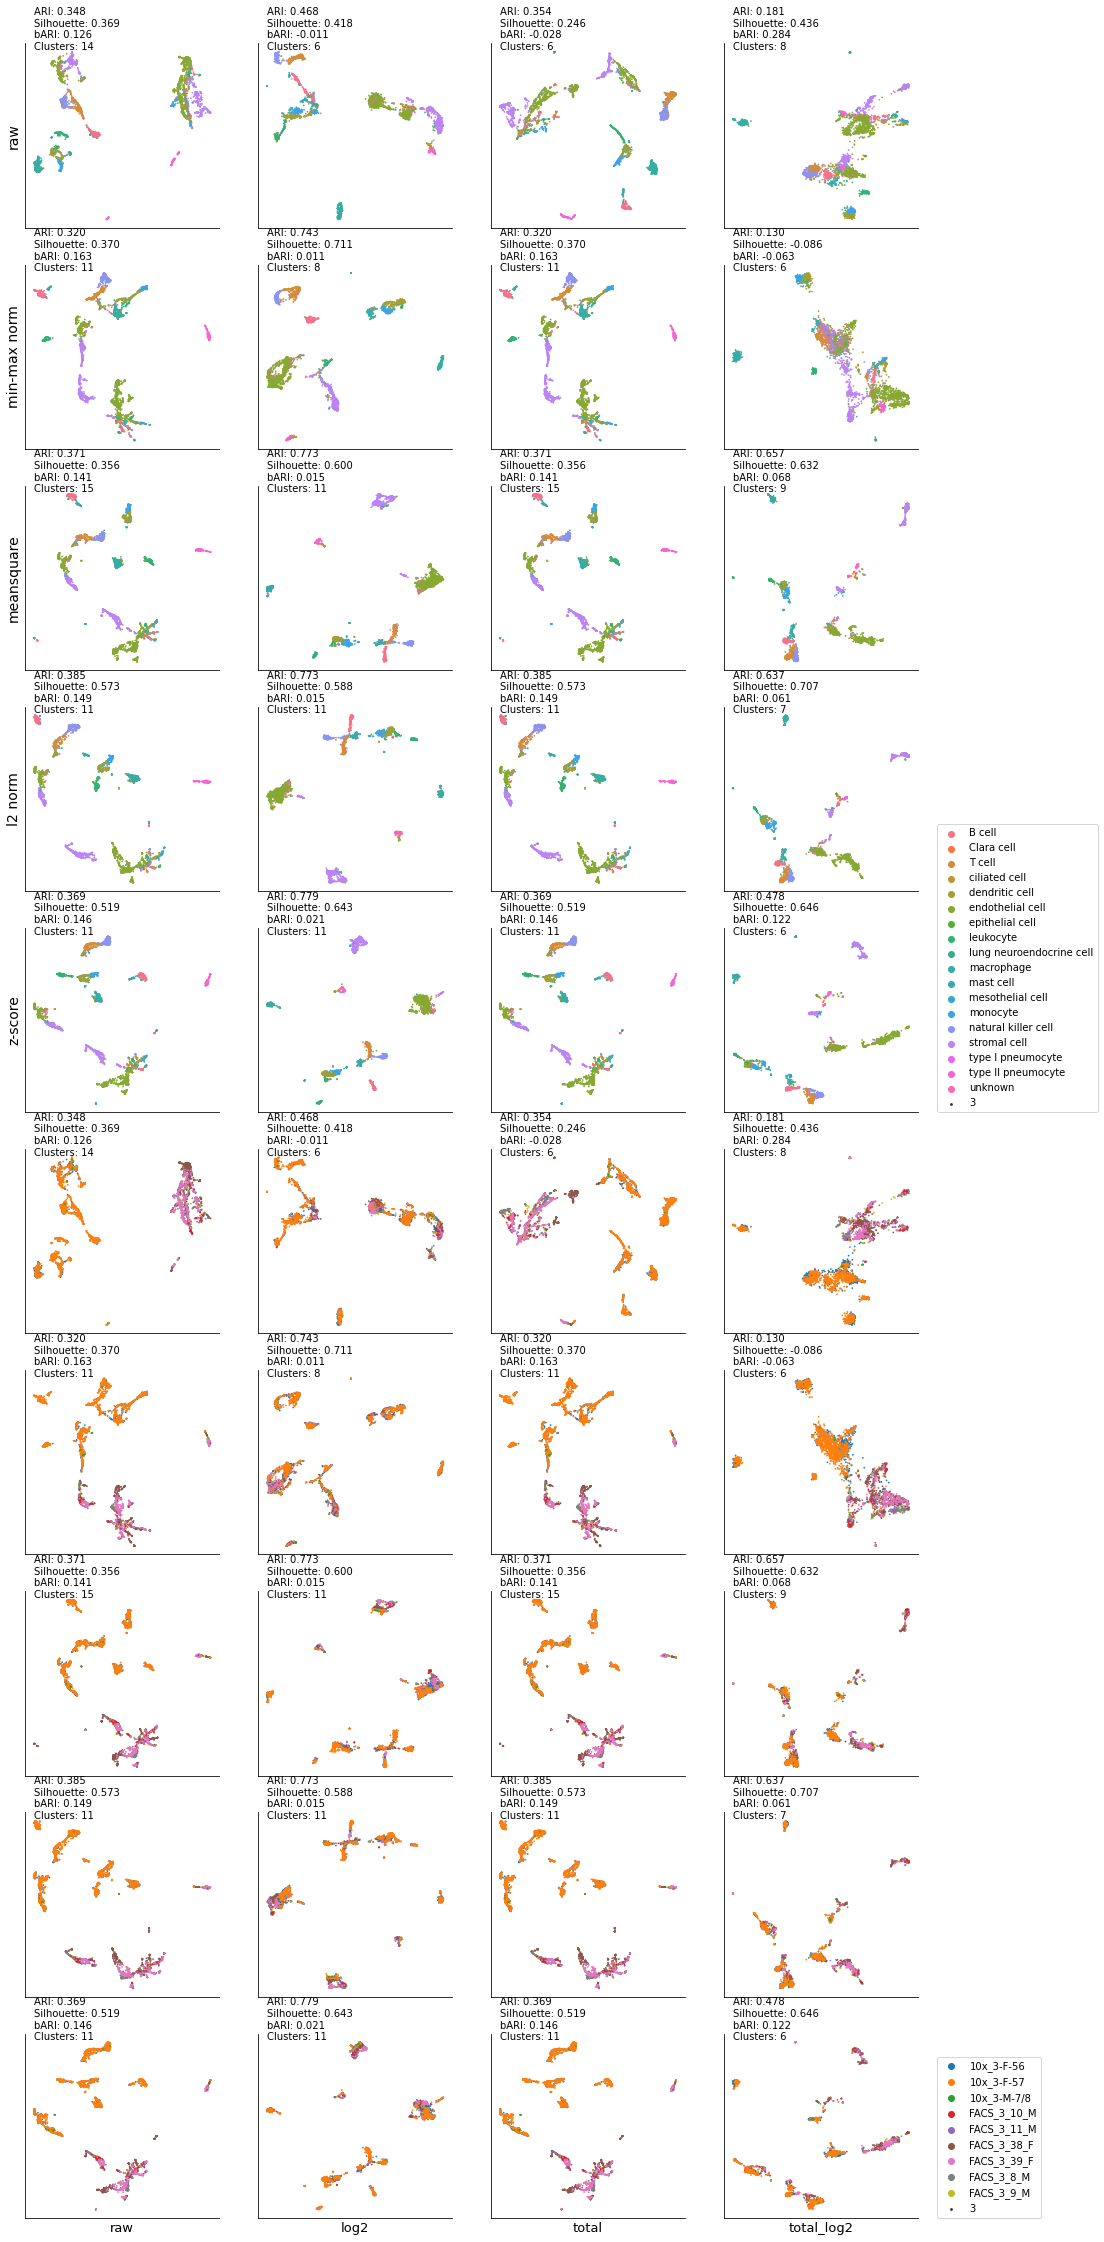

In [10]:
ORGAN = 'Lung'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 2000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))


total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Mammary_Gland-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Mammary_Gland-10X_P7_13', '../data/tabular_muris/01_droplet_raw_data/droplet/Mammary_Gland-10X_P7_12']
(2663, 23433)
{'luminal epithelial cell of mammary gland', 'stromal cell', 'endothelial cell', 'basal cell'}
(2543, 23433)
(4481, 23433)
{'macrophage', 'B cell', 'endothelial cell', 'stromal cell', 'basal cell', 'luminal cell of lactiferous duct', 'T cell'}

Summary
(6785, 23432)
{'Mammary_Gland'}
{'luminal epithelial cell of mammary gland', 'macrophage', 'B cell', 'endothelial cell', 'stromal cell', 'basal cell', 'luminal cell of lactiferous duct', 'T cell'}
{'FACS_3_38_F', '10x_3-F-57', 'FACS_3_57_F', '10x_3-F-56', 'FACS_3_56_F', 'FACS_3_39_F'}


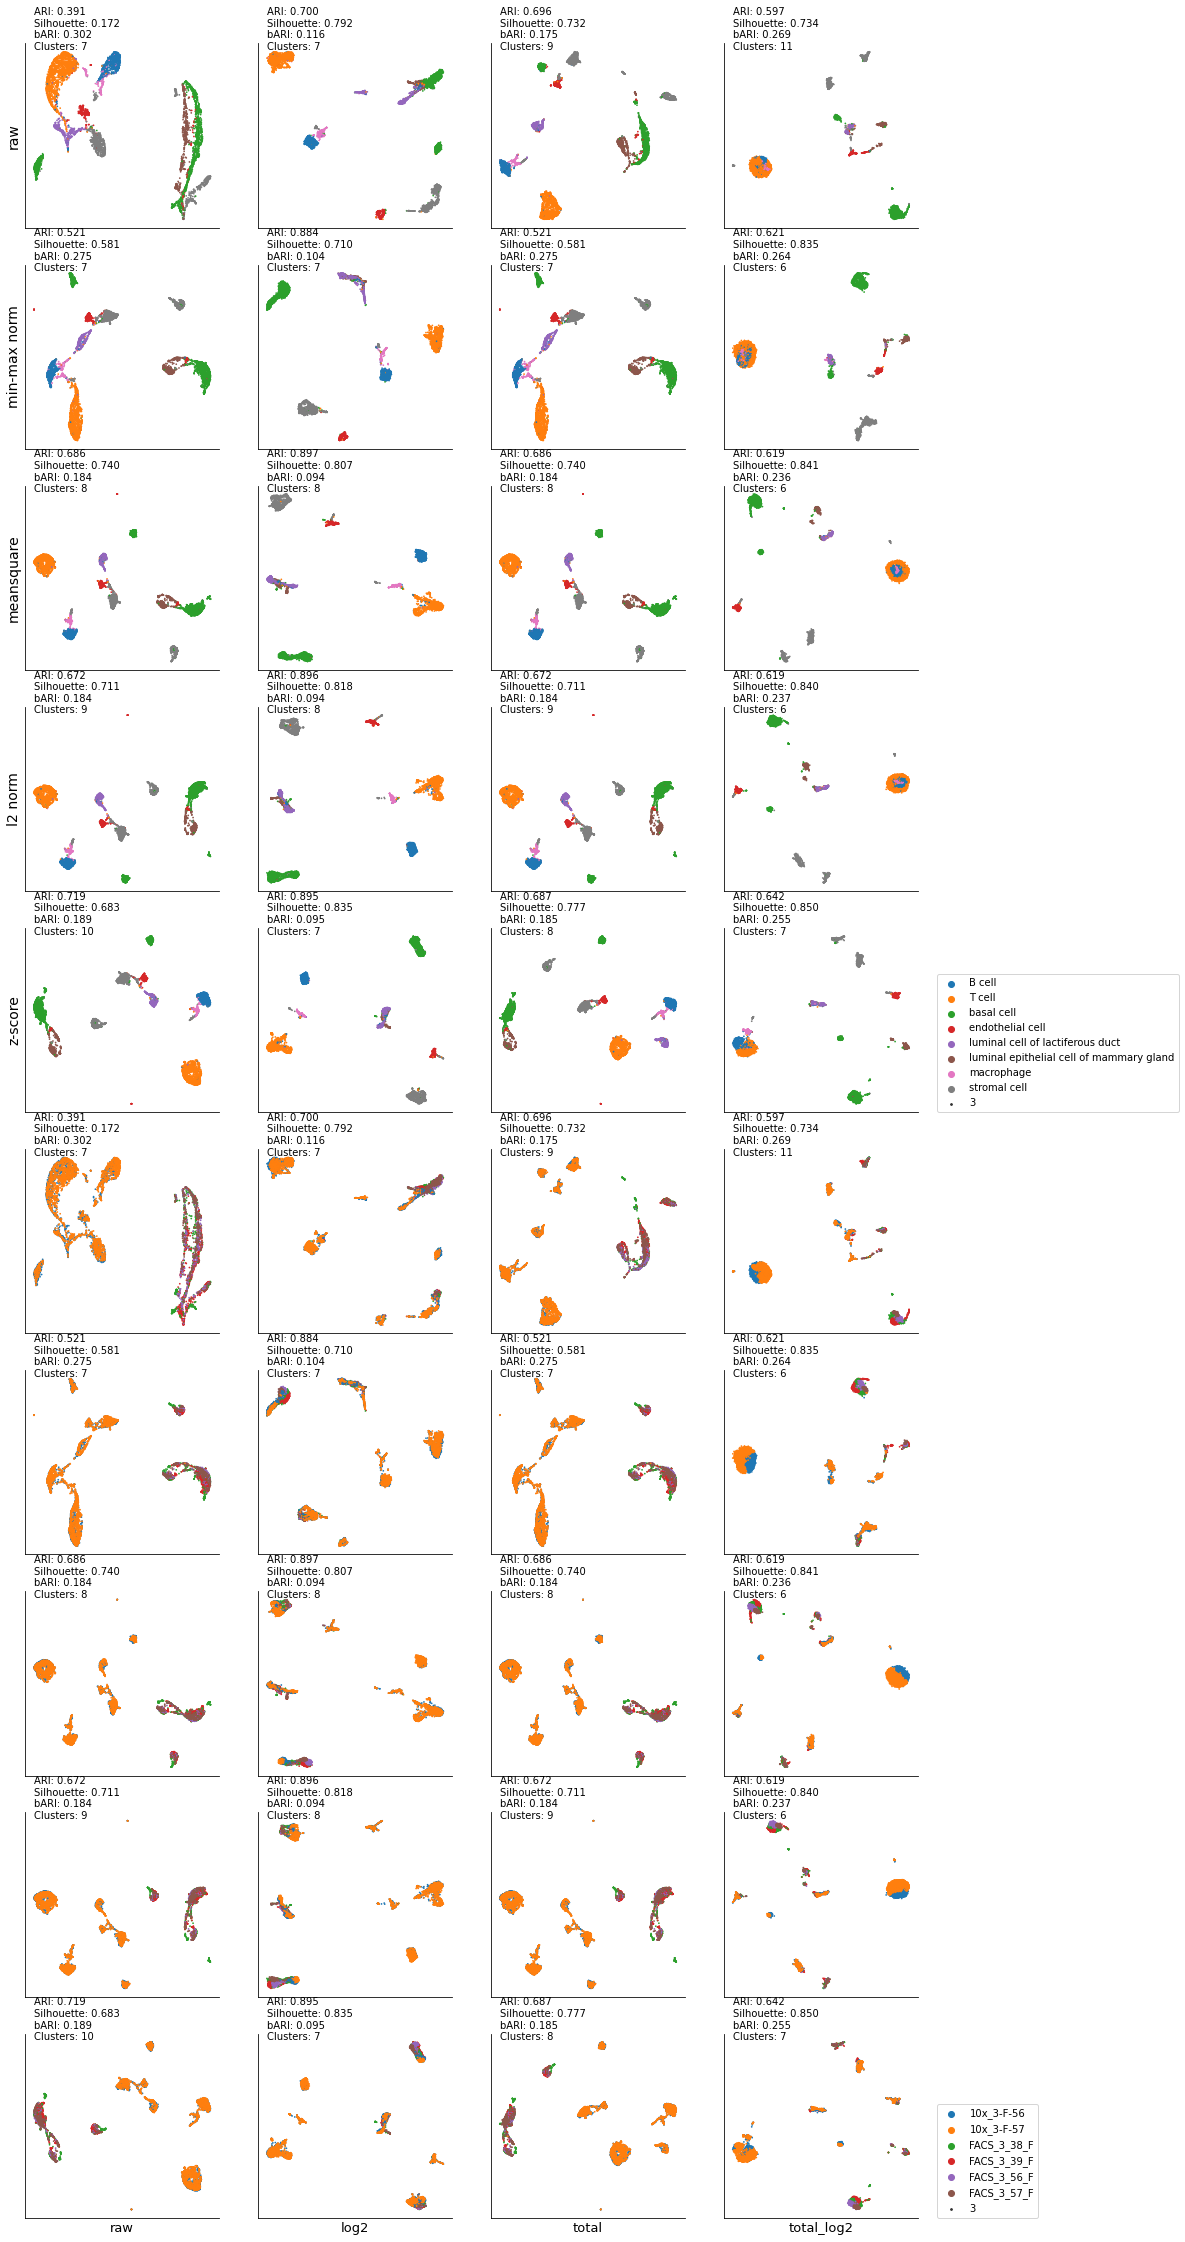

In [11]:
ORGAN = 'Mammary'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))


total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Marrow-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Marrow-10X_P7_2', '../data/tabular_muris/01_droplet_raw_data/droplet/Marrow-10X_P7_3']
(2000, 23433)
{'granulocyte', 'neutrophil', 'B cell', 'hematopoietic stem cell', 'Fraction A pre-pro B cell', 'natural killer cell', 'monocyte', 'T cell'}
(1981, 23433)
(3981, 23433)
{'macrophage', 'erythrocyte', 'granulocyte', 'B cell', 'hematopoietic stem cell', 'Fraction A pre-pro B cell', 'monocyte', 'T cell'}

Summary
(5368, 23432)
{'Marrow'}
{'macrophage', 'erythrocyte', 'granulocyte', 'neutrophil', 'B cell', 'hematopoietic stem cell', 'Fraction A pre-pro B cell', 'natural killer cell', 'monocyte', 'T cell'}
{'FACS_3_38_F', 'FACS_3_10_M', '10x_3-F-57', '10x_3-F-56', 'FACS_3_8_M', 'FACS_3_39_F', 'FACS_3_9_M'}


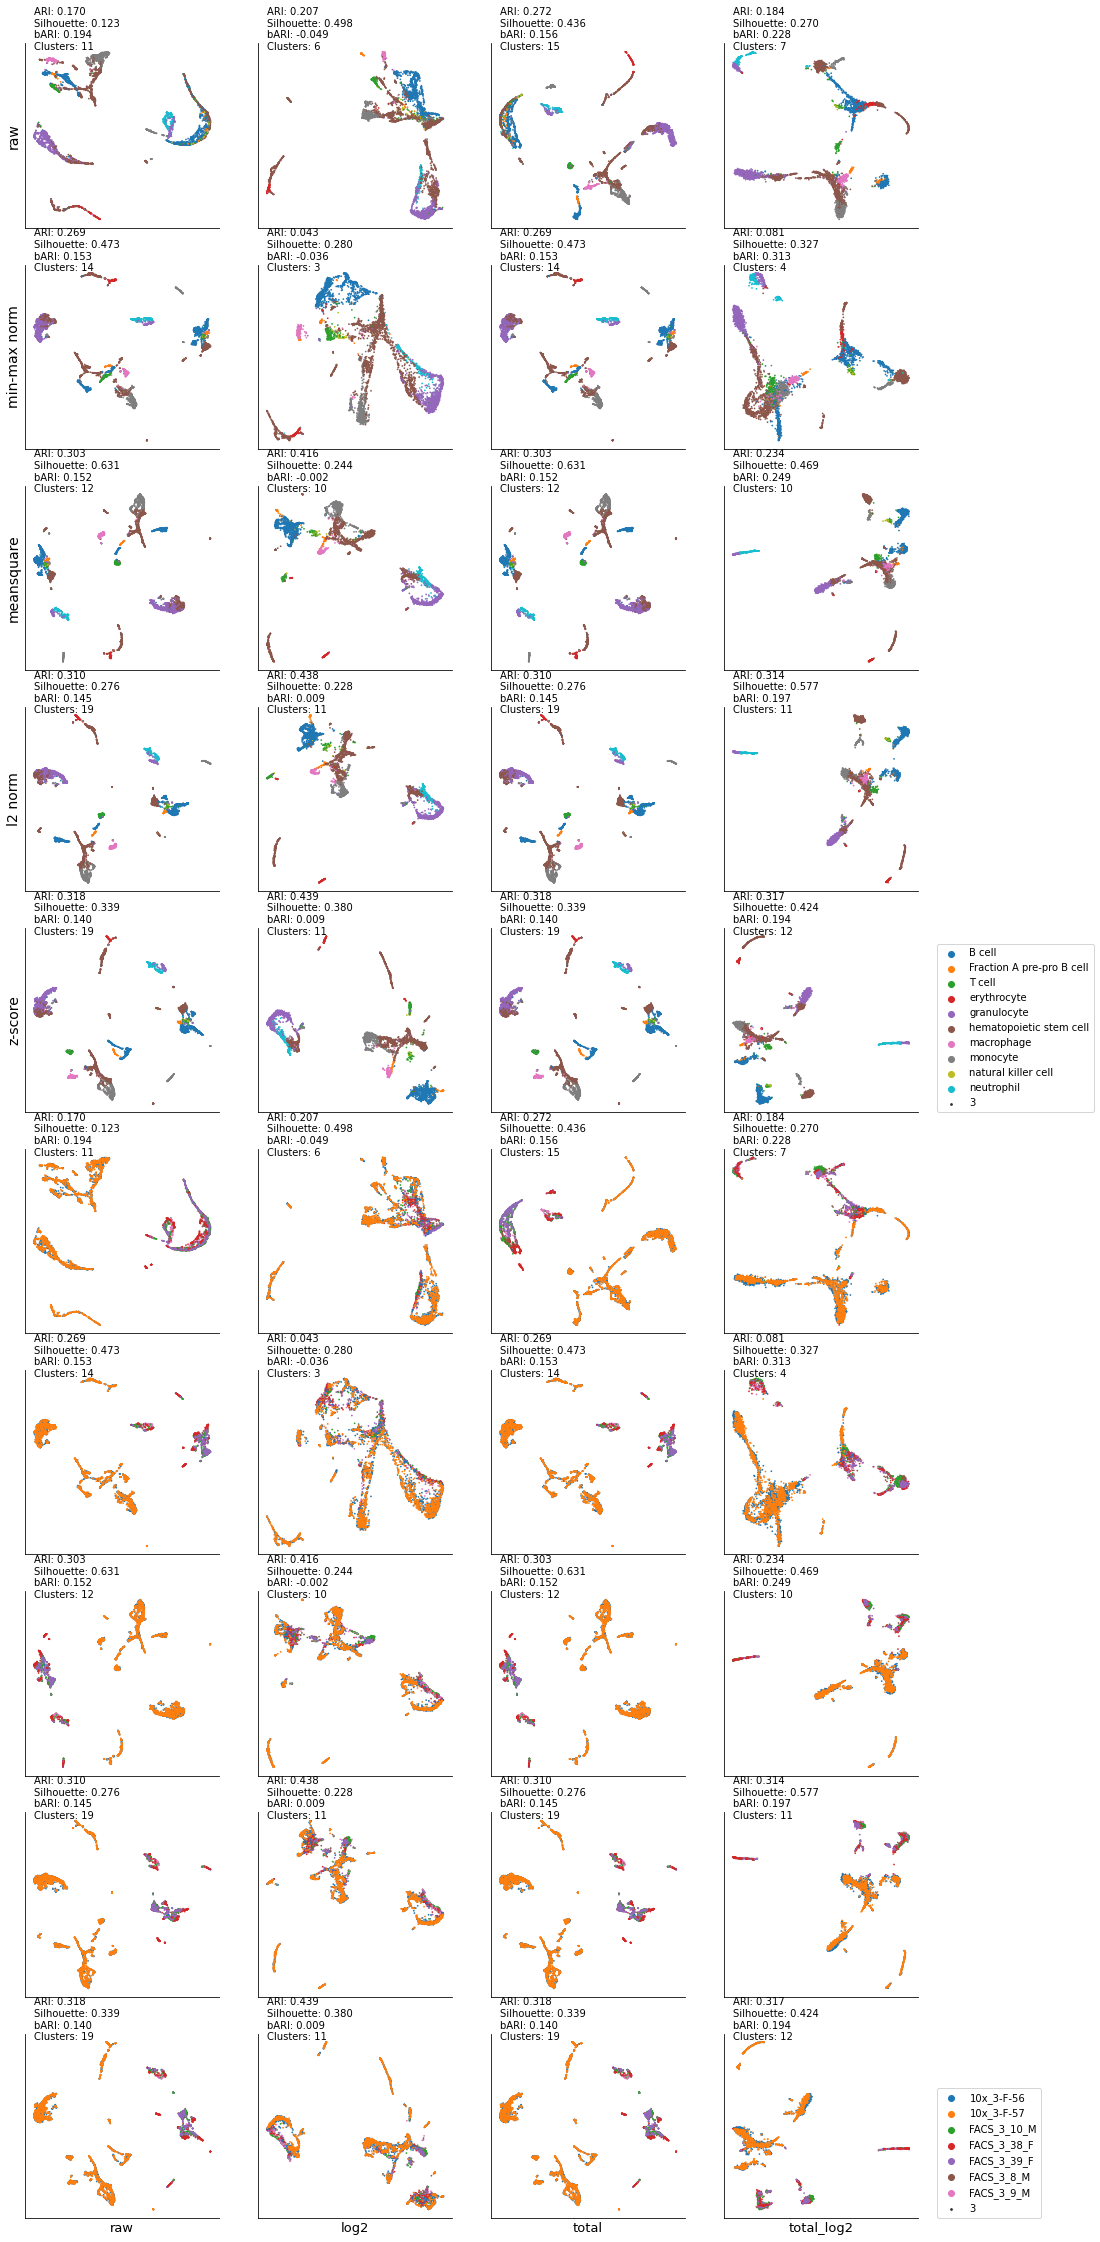

In [12]:
ORGAN = 'Marrow'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
sample_per_class = 2000

tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 2000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Spleen-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Spleen-10X_P7_6', '../data/tabular_muris/01_droplet_raw_data/droplet/Spleen-10X_P4_7']
(1718, 23433)
{'myeloid cell', 'B cell', 'T cell'}
(2000, 23433)
(4000, 23433)
{'B cell', 'macrophage', 'T cell', 'dendritic cell'}

Summary
(5674, 23432)
{'Spleen'}
{'macrophage', 'myeloid cell', 'B cell', 'dendritic cell', 'T cell'}
{'FACS_3_10_M', 'FACS_3_38_F', '10x_3-F-56', 'FACS_3_8_M', 'FACS_3_11_M', 'FACS_3_39_F', 'FACS_3_9_M', '10x_3-M-8'}


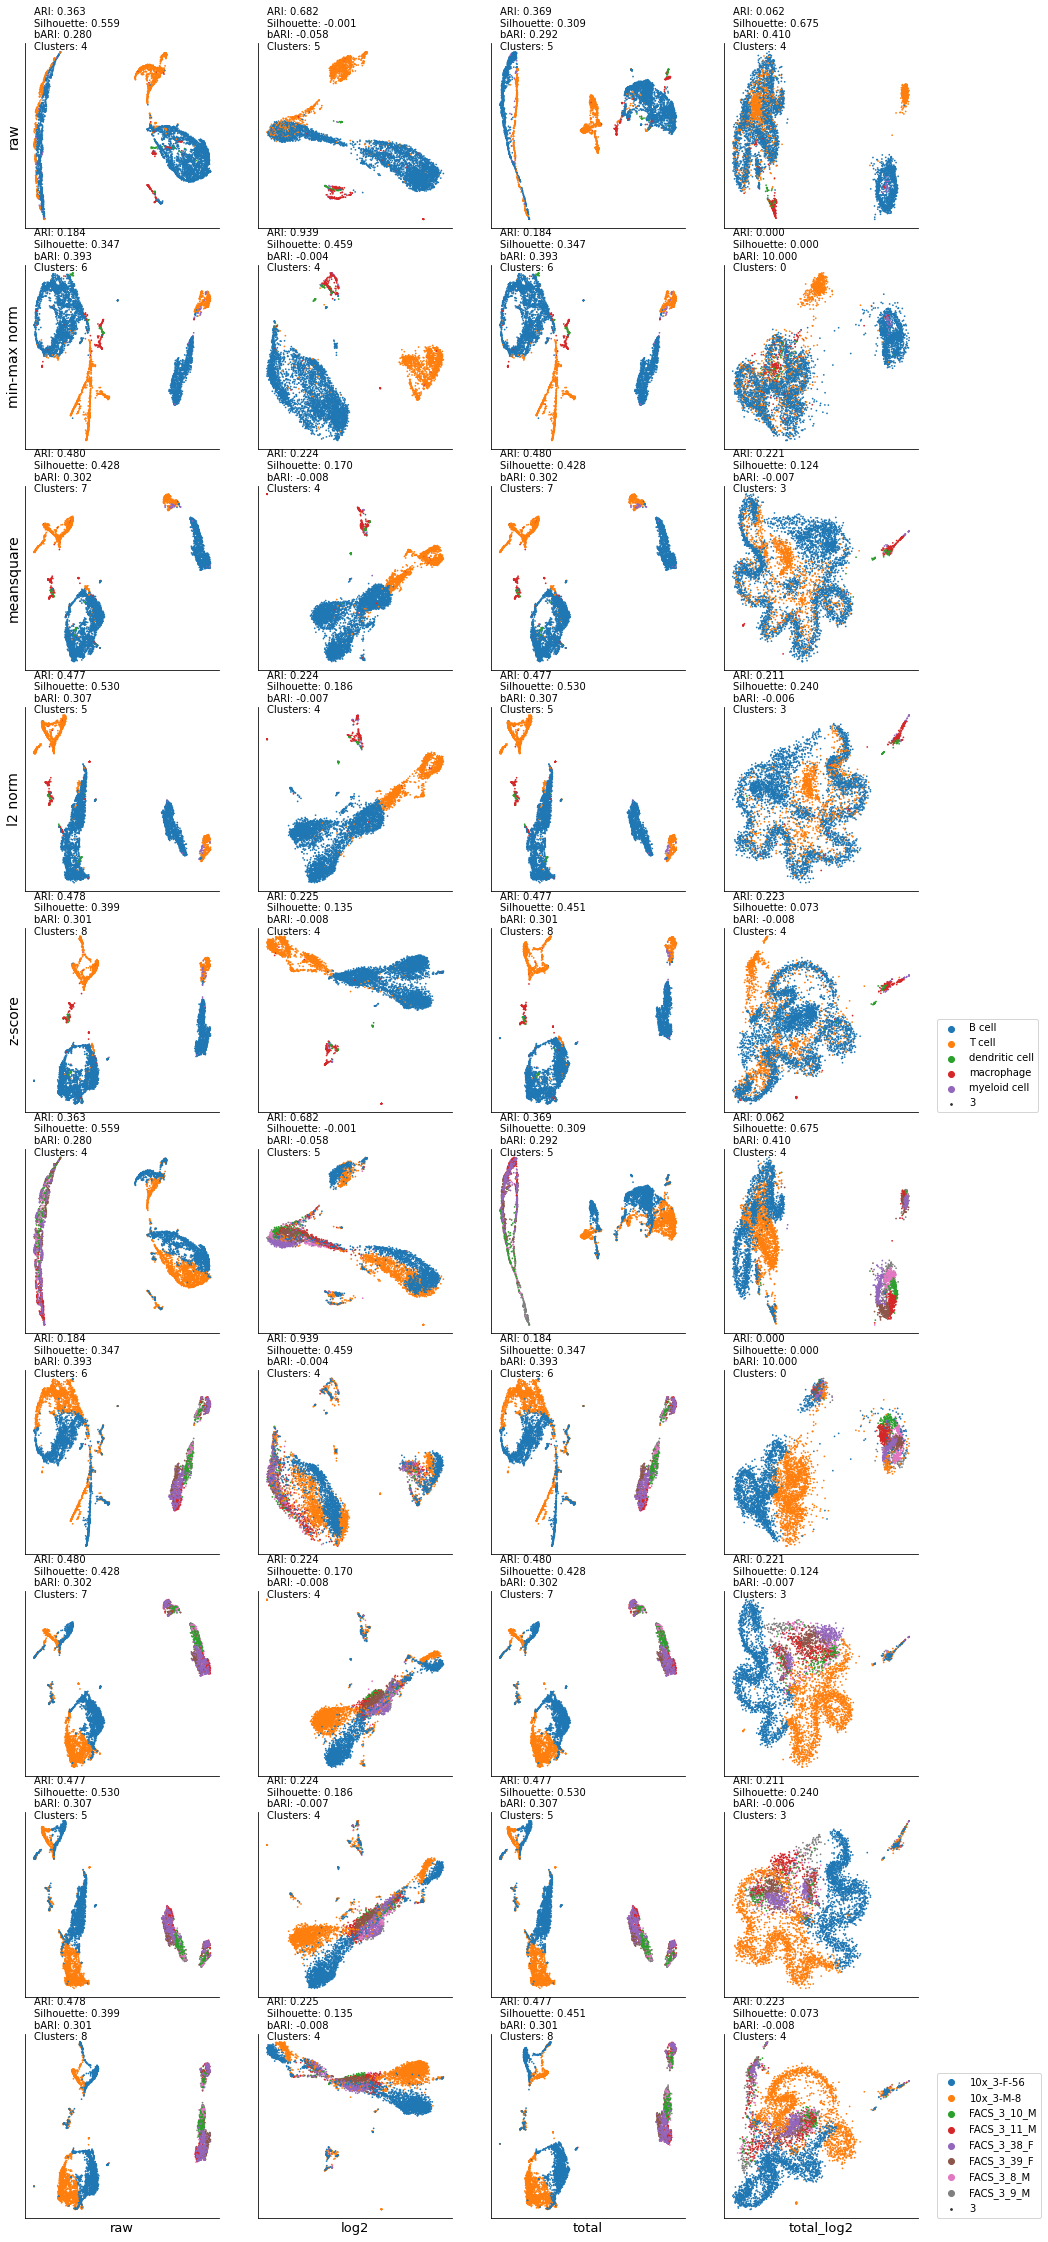

In [13]:
ORGAN = 'Spleen'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 2000
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Thymus-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Thymus-10X_P7_11']
(1580, 23433)
{'mesenchymal stem cell', 'T cell'}
(1431, 23433)
{'stromal cell', 'T cell'}

Summary
(2712, 23432)
{'Thymus'}
{'mesenchymal stem cell', 'stromal cell', 'T cell'}
{'FACS_3_38_F', '10x_3-F-56', 'FACS_3_8_M', 'FACS_3_11_M', 'FACS_3_39_F', 'FACS_3_9_M'}


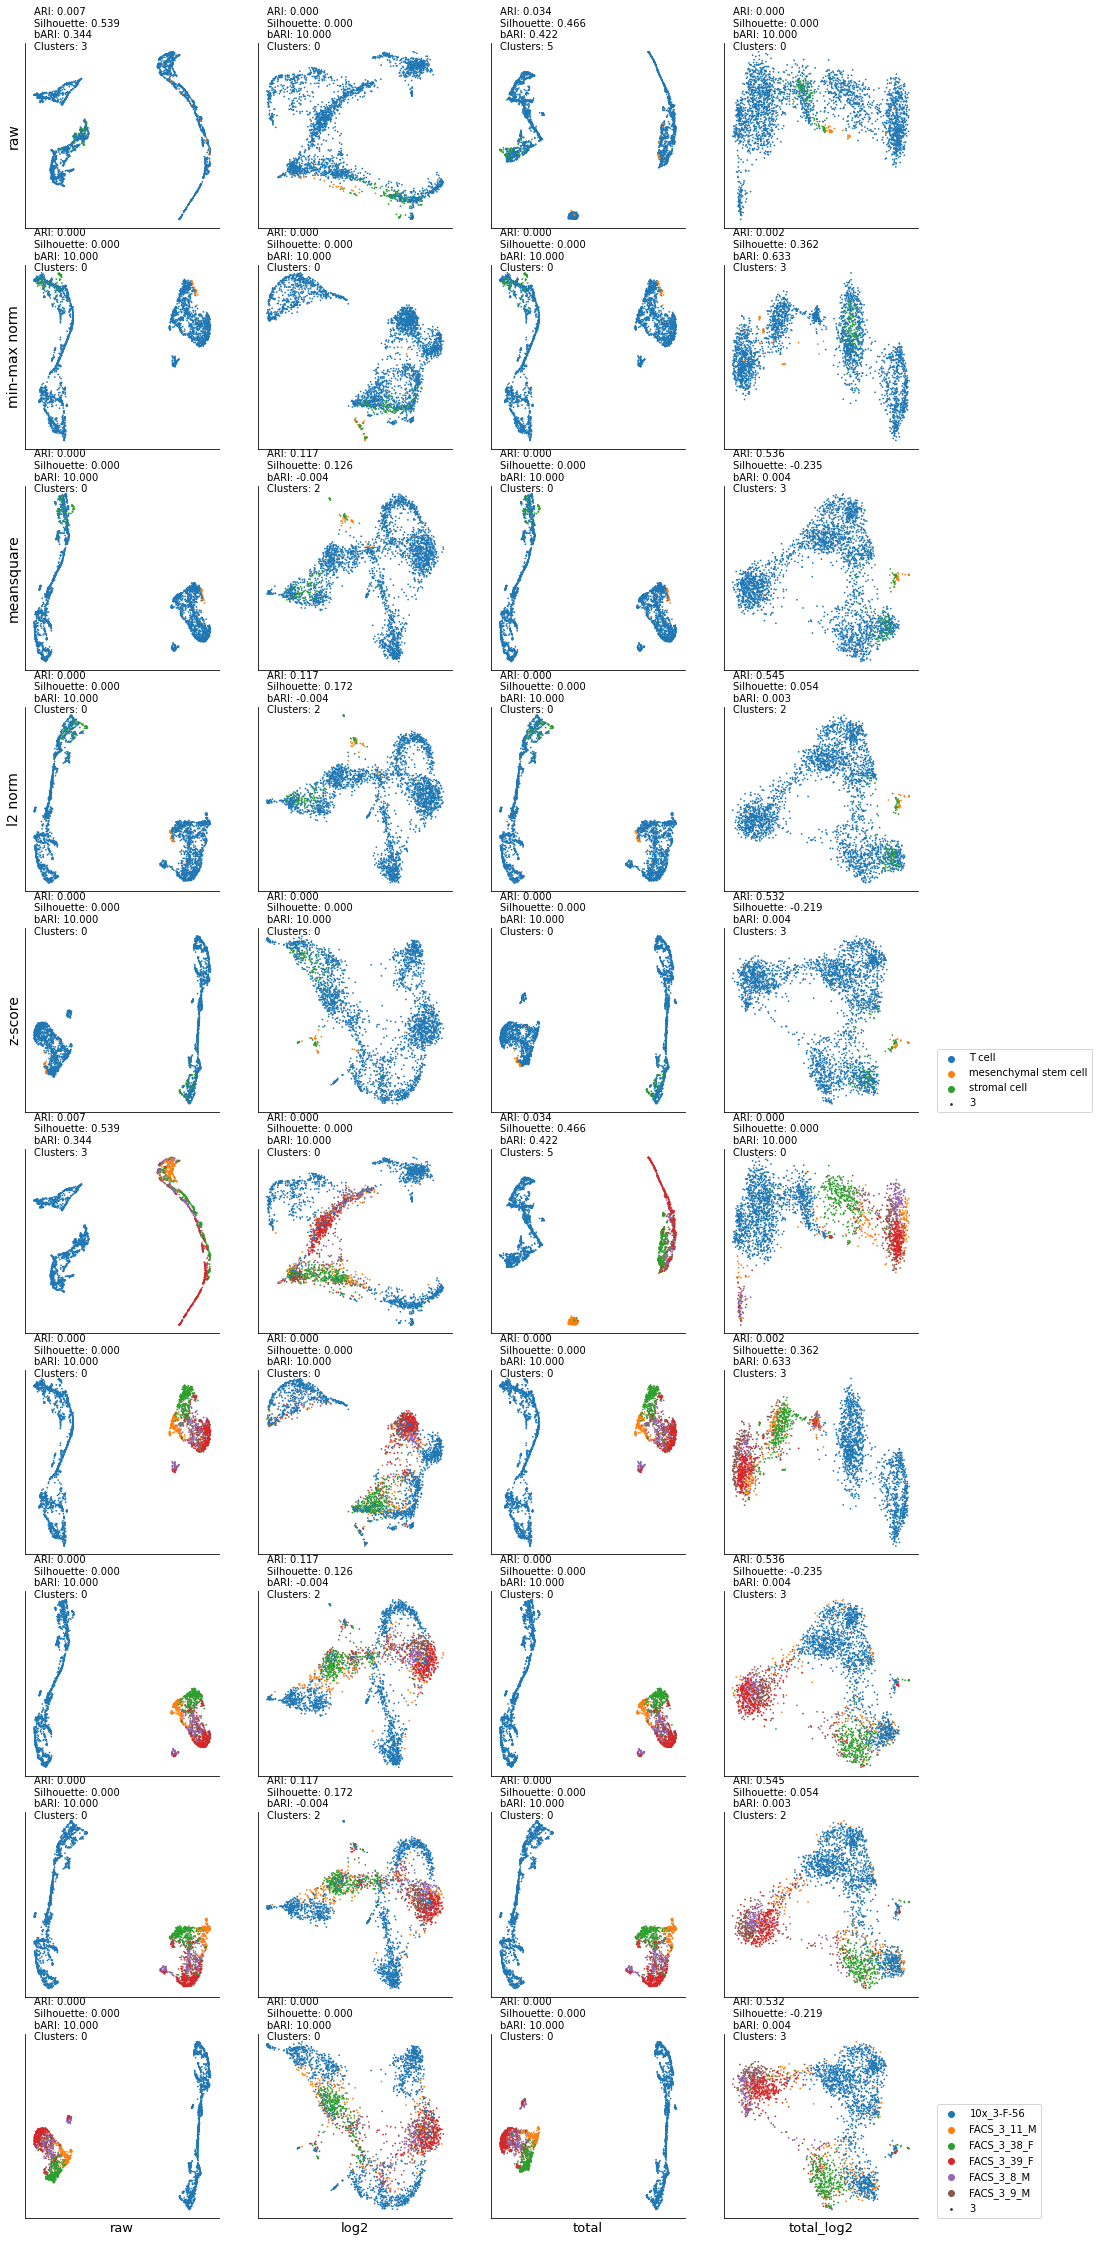

In [14]:
ORGAN = 'Thymus'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)


# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Tongue-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Tongue-10X_P7_10', '../data/tabular_muris/01_droplet_raw_data/droplet/Tongue-10X_P4_1', '../data/tabular_muris/01_droplet_raw_data/droplet/Tongue-10X_P4_0']
(1432, 23433)
{'keratinocyte', 'basal cell of epidermis'}
(1000, 23433)
(2000, 23433)
(3000, 23433)
{'unknown', 'keratinocyte', 'basal cell of epidermis'}

Summary
(4394, 23432)
{'Tongue'}
{'unknown', 'keratinocyte', 'basal cell of epidermis'}
{'FACS_3_38_F', 'FACS_3_10_M', '10x_3-F-56', 'FACS_3_8_M', '10x_3-M-9', 'FACS_3_39_F', 'FACS_3_9_M', '10x_3-M-8'}


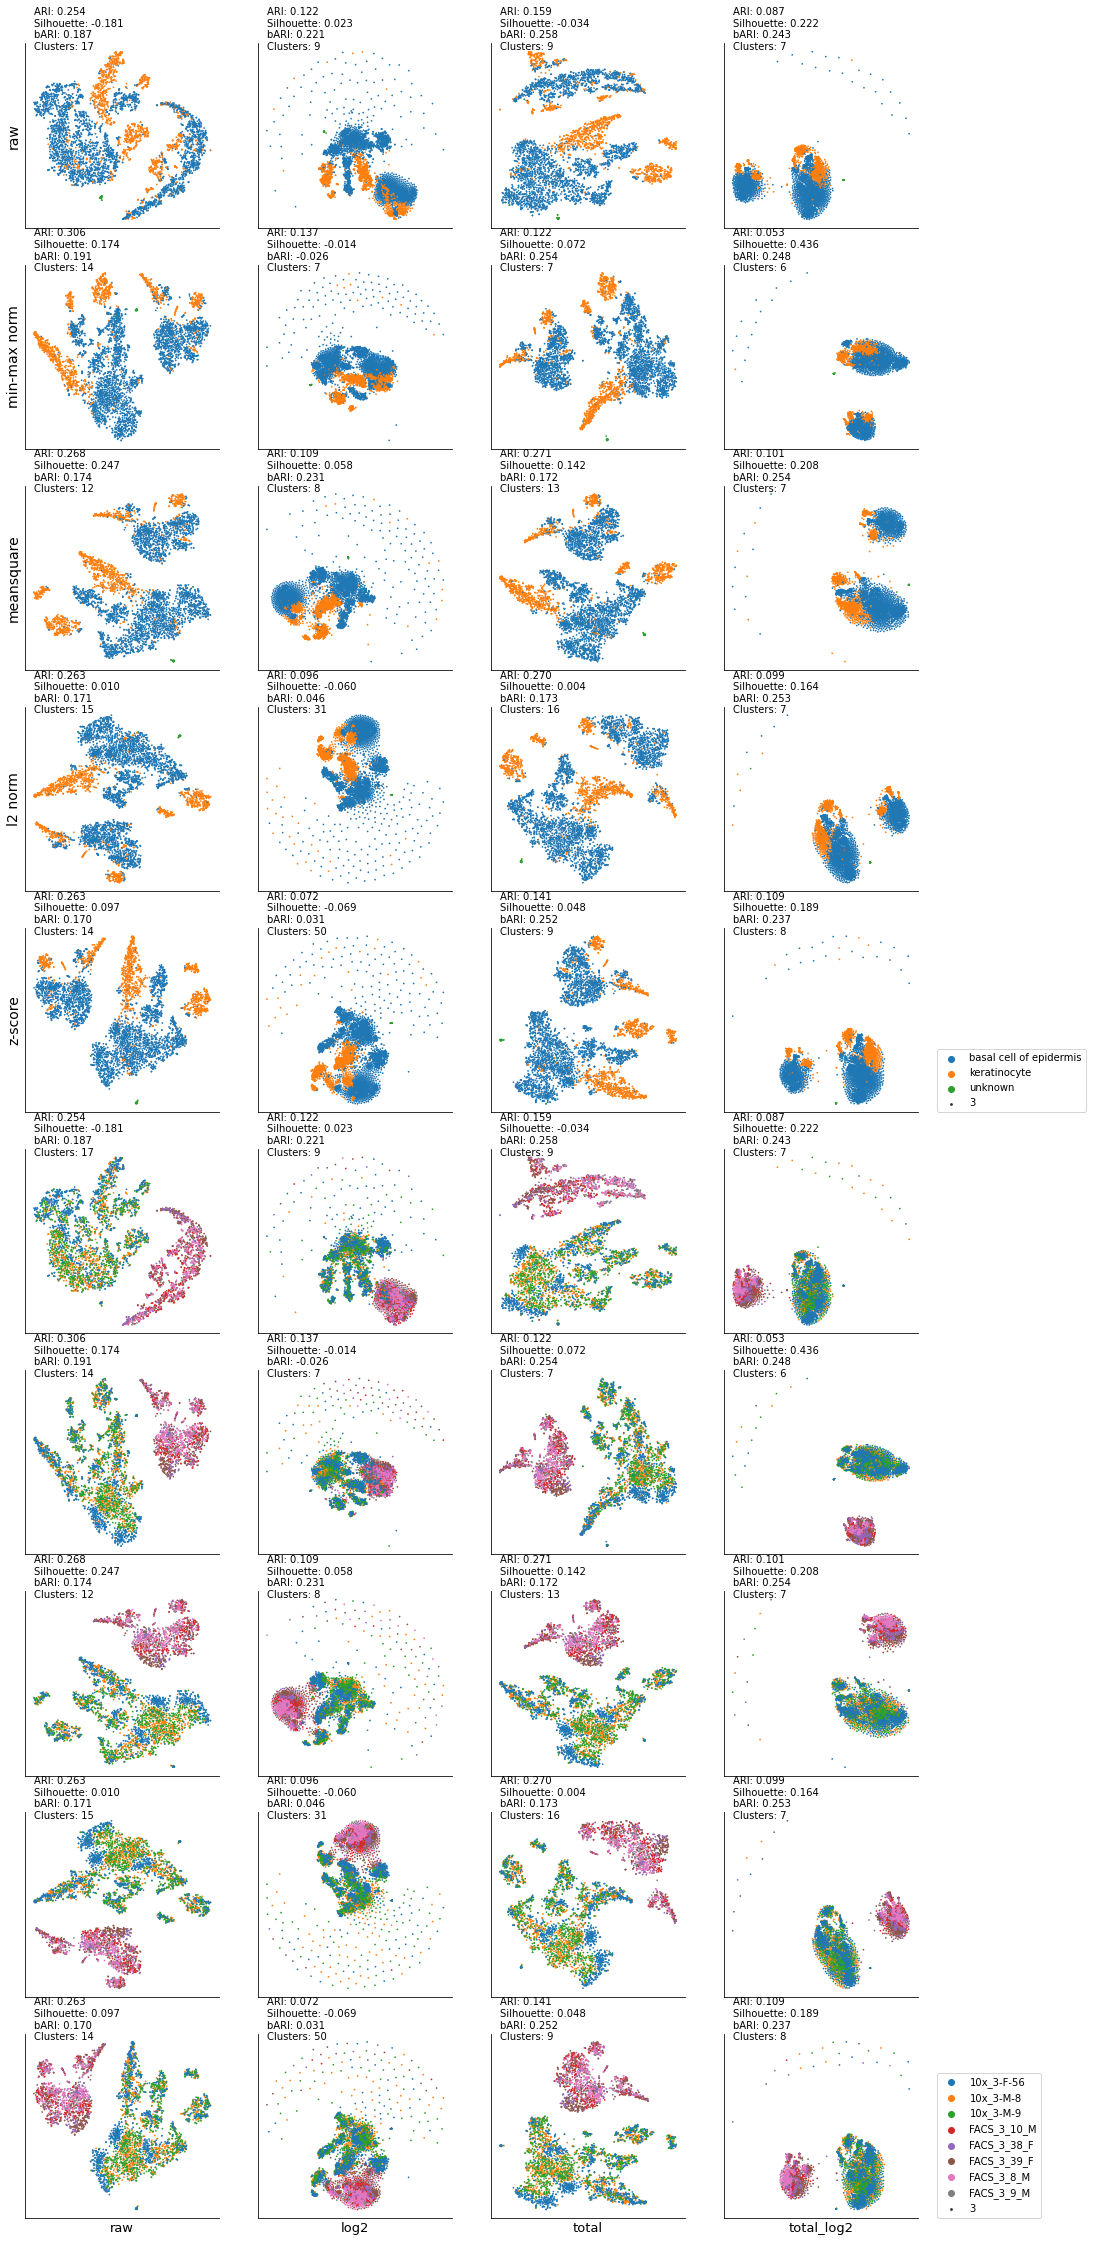

In [15]:
ORGAN = 'Tongue'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class=1000
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)



# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

['../data/tabular_muris/00_facs_raw_data/FACS/Trachea-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Trachea-10X_P8_14', '../data/tabular_muris/01_droplet_raw_data/droplet/Trachea-10X_P8_15']
(1391, 23433)
{'leukocyte', 'stromal cell', 'epithelial cell', 'endothelial cell'}
(5000, 23433)
(10000, 23433)
{'neuroendocrine cell', 'endothelial cell', 'stromal cell', 'epithelial cell', 'leukocyte'}

Summary
(911, 23432)
{'Trachea'}
{'neuroendocrine cell', 'endothelial cell', 'stromal cell', 'epithelial cell', 'leukocyte'}
{'FACS_3_10_M', 'FACS_3_38_F', '10x_3-M-7/8', 'FACS_3_39_F', '10x_3-M-5/6'}


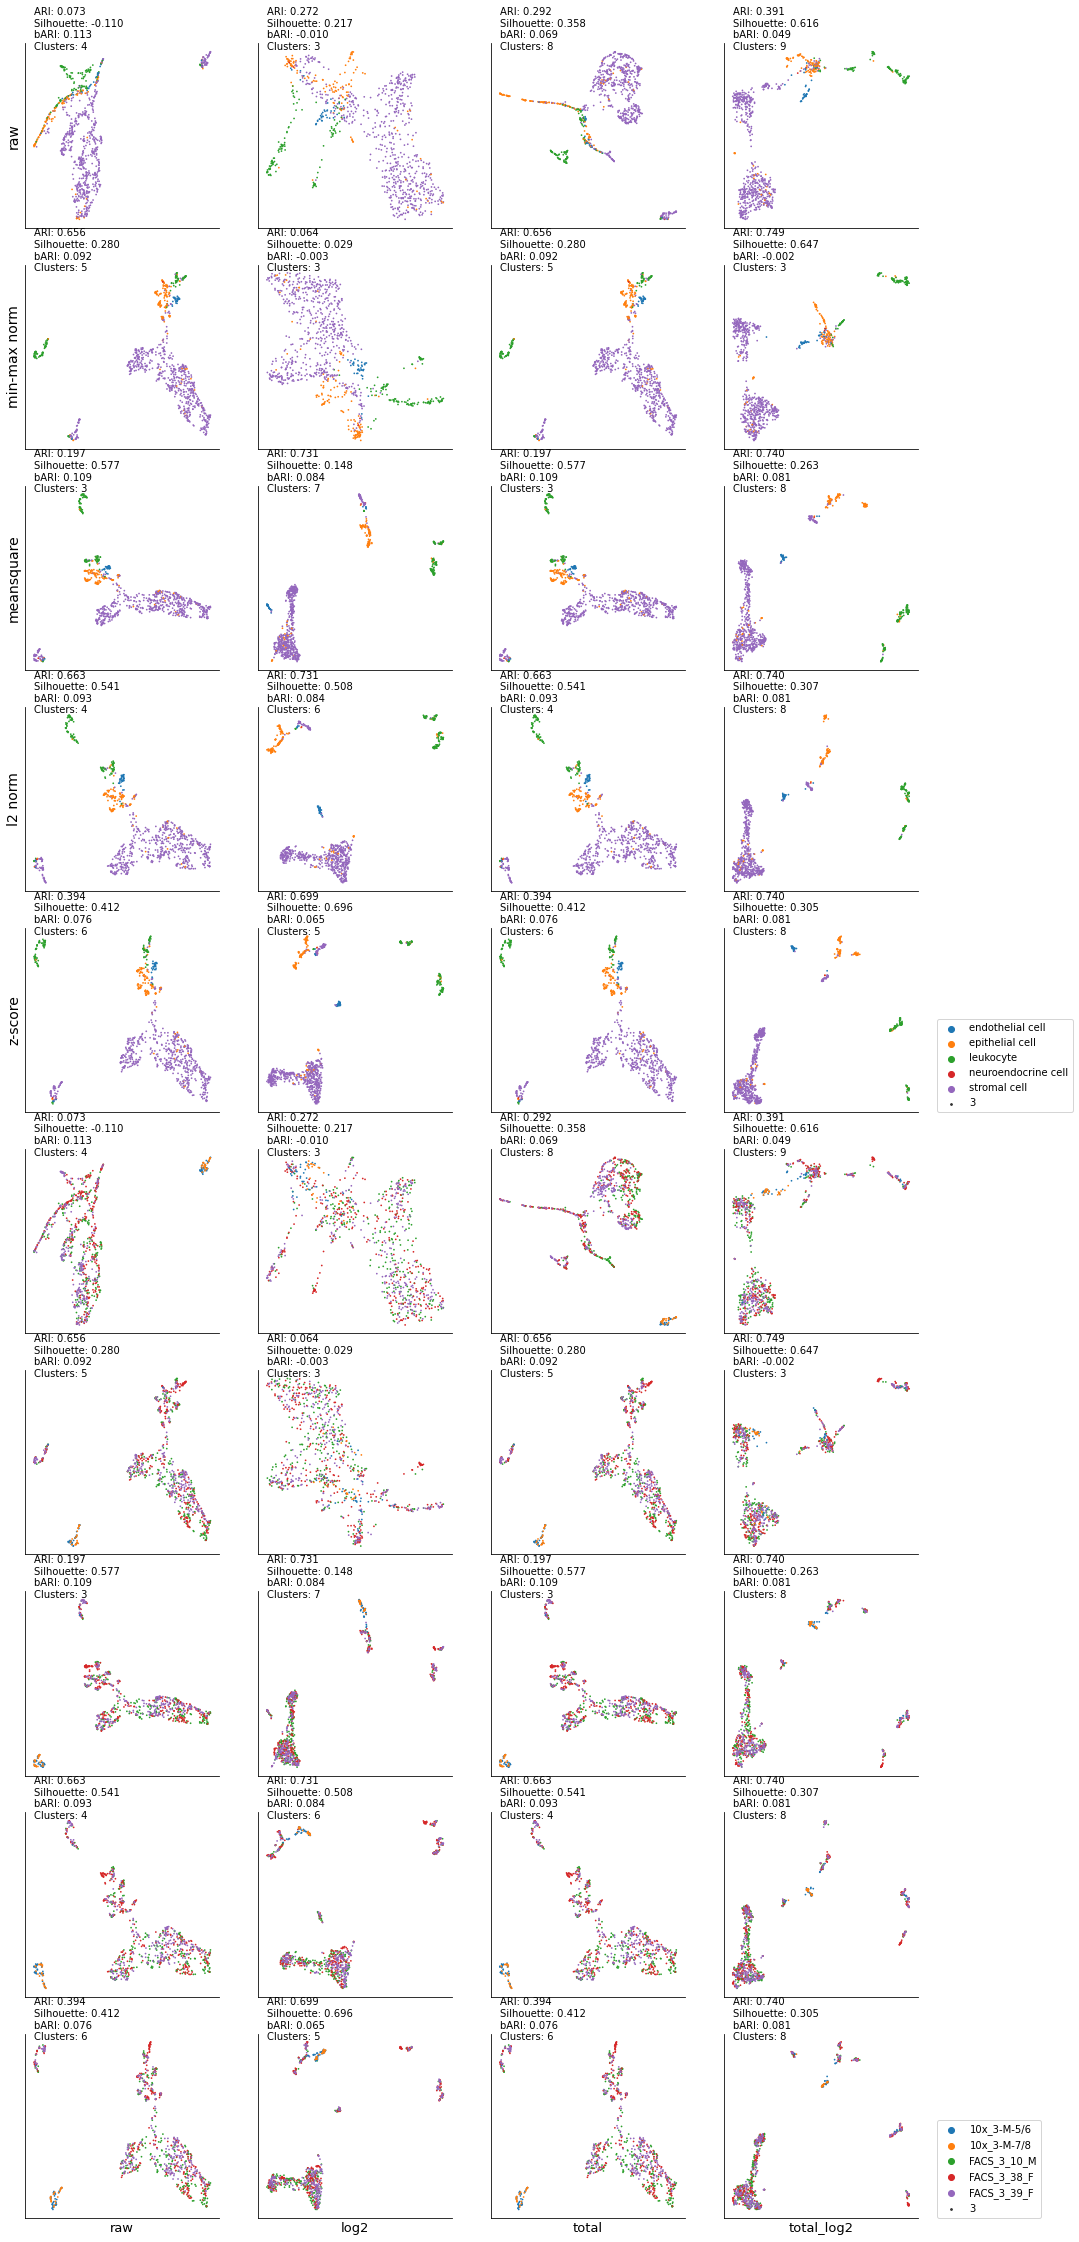

In [16]:
ORGAN = 'Trachea'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class=5000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))



total_data = pd.concat([tabula_data, tabula_10x_data], axis=0)
labels = tissue + tissue_10x #mca_labels
labels_cell = tabula_labels + tabula_10x_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

#latent_space = TSNE(n_components=2)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels_cell, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)